In [1]:
import tensorflow as tf
tf.version.VERSION

'2.3.0'

In [9]:
import numpy as np
import tensorflow_hub as hub
import sys
sys.path.append('../tmp/models')
import os

In [6]:
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
# from official import optimization

ImportError: cannot import name 'optimization' from 'official' (../tmp/models\official\__init__.py)

In [7]:
print('TF Version: ', tf.__version__)
print('Eager Mode: ', tf.executing_eagerly())
print('Hub version: ', hub.__version__ )
print("GPU is ", "available" if tf.config.experimental.list_physical_devices("GPU") else "not available")

TF Version:  2.3.0
Eager Mode:  True
Hub version:  0.9.0
GPU is  available


In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [11]:
os.listdir('data')

['train.csv']

In [12]:
pdf = pd.read_csv(os.path.join('data', 'train.csv'))

In [13]:
pdf.shape

(1306122, 3)

In [15]:
pdf.head(10)

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
5,00004f9a462a357c33be,"Is Gaza slowly becoming Auschwitz, Dachau or T...",0
6,00005059a06ee19e11ad,Why does Quora automatically ban conservative ...,0
7,0000559f875832745e2e,Is it crazy if I wash or wipe my groceries off...,0
8,00005bd3426b2d0c8305,"Is there such a thing as dressing moderately, ...",0
9,00006e6928c5df60eacb,Is it just me or have you ever been in this ph...,0


In [16]:
pdf.tail(20)

,qid,question_text,target
1306102,ffff3778790af9baae76,What steps can I take to live a normal life if...,0
1306103,ffff3f0a2449ffe4b9ff,Isn't Trump right after all? Why should the US...,1
1306104,ffff41393389d4206066,Is 33 too late for a career in creative advert...,0
1306105,ffff42493fc203cd9532,What is difference between the filteration wor...,0
1306106,ffff48dd47bee89fff79,"If the universe ""popped"" into existence from n...",0
1306107,ffff5fd051a032f32a39,How does a shared service technology team meas...,0
1306108,ffff6d528040d3888b93,How is DSATM civil engineering?,0
1306109,ffff8776cd30cdc8d7f8,Do you know any problem that depends solely on...,0
1306110,ffff94d427ade3716cd1,What are some comic ideas for you Tube videos ...,0
1306111,ffffa382c58368071dc9,"If you had $10 million of Bitcoin, could you s...",0


In [18]:
pdf.tail(20).iloc[1]['question_text']

"Isn't Trump right after all? Why should the USA be benevolent towards it's neighbor Mexico, and not put America first, when Russia is invading Ukraine? Even India imposed a blockade over Nepal after an earthquake?"

<AxesSubplot:ylabel='Frequency'>

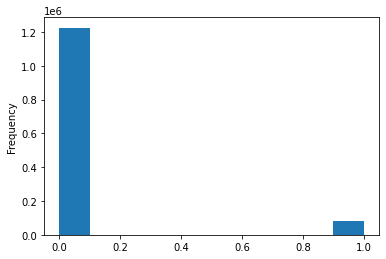

In [19]:
pdf.target.plot(kind='hist')

In [26]:
train_df, valid_df = train_test_split(pdf, random_state=32, train_size=.9, stratify= pdf.target.values)

In [27]:
train_df.target.value_counts(normalize=True)

0    0.93813
1    0.06187
Name: target, dtype: float64

In [28]:
valid_df.target.value_counts(normalize=True)

0    0.93813
1    0.06187
Name: target, dtype: float64

In [29]:
with tf.device('/cpu:0'):
    train_data = tf.data.Dataset.from_tensor_slices((train_df['question_text'].values, train_df['target'].values))
    valid_data = tf.data.Dataset.from_tensor_slices((valid_df['question_text'].values, valid_df['target'].values))
    
    for text, label in train_data.take(1):
        print(text)
        print(label)

tf.Tensor(b'What do Moroccans think of Pakistan?', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


In [30]:
"""
Each line of the dataset is composed of the review text and its label
First we will transform the text to BERT input features:
input_word_ids, input_mask, segment_ids
In this process, tokenizing the text is done with the provided BERT model tokenizer
"""
label_list = [0, 1] # label categories
max_seq_length = 128 # maximum length of (token) input sequences
train_batch_size = 32


In [31]:
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length, ), dtype=tf.int32,
                                      name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length, ), dtype=tf.int32,
                                  name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length, ), dtype=tf.int32,
                                   name="segment_ids")
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",
                           trainable=True)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

In [32]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [37]:
tokenizer.wordpiece_tokenizer.tokenize('hi, how yaaaa doing?')

['hi', '##,', 'how', 'ya', '##aa', '##a', 'doing', '##?']

In [36]:
tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize('hi, how you doing?'))

[7632, 29623, 2129, 2017, 2725, 29632]

In [40]:
def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
    example = classifier_data_lib.InputExample(guid=None,
                                              text_a = text.numpy(),
                                              text_b = None,
                                              label=label.numpy())
    feature = classifier_data_lib.convert_single_example(0, example, label_list, max_seq_length, tokenizer)
    return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)
    

In [55]:
def to_feature_map(text, label):
    input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text, label],
                                                                 Tout=[tf.int32, tf.int32, tf.int32, tf.int32])
    input_ids.set_shape([max_seq_length])
    input_mask.set_shape([max_seq_length])
    segment_ids.set_shape([max_seq_length])
    label_id.set_shape([])
    
    x = {
        'input_word_ids': input_ids,
        'input_mask': input_mask, 
        'input_type_ids': segment_ids
    }
    return (x, label_id)

In [57]:
with tf.device(':/cpu:0'):
    # train
    train_data = (train_data.map(to_feature_map, 
                                num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .shuffle(1000)
    .batch(32, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))
    
    valid_data = (valid_data.map(to_feature_map, 
                                num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(32, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

In [58]:
train_data.element_spec

({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [59]:
valid_data.element_spec

({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [65]:
def create_model():
    input_word_ids = tf.keras.layers.Input(shape=(max_seq_length, ), dtype=tf.int32,
                                      name="input_word_ids")
    input_mask = tf.keras.layers.Input(shape=(max_seq_length, ), dtype=tf.int32,
                                  name="input_mask")
    segment_ids = tf.keras.layers.Input(shape=(max_seq_length, ), dtype=tf.int32,
                                   name="segment_ids")
    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    drop = tf.keras.layers.Dropout(0.4)(pooled_output)
    output = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(drop)
    
    model = tf.keras.Model(
        inputs={
            'input_word_ids': input_word_ids,
            'input_mask': input_mask, 
            'input_type_ids': segment_ids
        }, 
        outputs = output
    )
    return model

In [66]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
             loss=tf.keras.losses.BinaryCrossentropy(),
             metrics=[tf.keras.metrics.BinaryAccuracy()])

In [67]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

In [72]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=76)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [78]:
epochs = 2
history = model.fit(train_data, validation_data=valid_data, epochs=epochs)

Epoch 1/2
    2/36734 [..............................] - ETA: 3:17:44 - loss: 0.0613 - binary_accuracy: 0.9688WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0210s vs `on_train_batch_end` time: 0.3040s). Check your callbacks.


36734/36734 [==============================] - ETA: 0s - loss: 0.0836 - binary_accuracy: 0.9668WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0150s vs `on_test_batch_end` time: 0.1010s). Check your callbacks.


36734/36734 [==============================] - 12867s 350ms/step - loss: 0.0836 - binary_accuracy: 0.9668 - val_loss: 0.0939 - val_binary_accuracy: 0.9632
Epoch 2/2
36734/36734 [==============================] - 13185s 359ms/step - loss: 0.0633 - binary_accuracy: 0.9750 - val_loss: 0.1124 - val_binary_accuracy: 0.9633


In [77]:
# testing on real data 
sample_examples = ["hello, is this a place for questions?", "Is China the worst?"]
test_data = tf.data.Dataset.from_tensor_slices((sample_examples, [0]*len(sample_examples)))
test_data = ((test_data.map(to_feature_map).batch(1)))
preds = model.predict(test_data)
threshold = 0.5
['Insincere' if pred >= threshold else 'Sincere' for pred in preds]

['Sincere', 'Sincere']